In [20]:
# Load Required Libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

import seaborn as sns   # Heatmap plot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Algorithm Models to import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# All performance Metrics
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE


In [37]:
# Get Error Type
def get_error_type(pred, label):
    # return the type of error: tp,fp,tn,fn
    if pred == label:
        return "tp" if pred == 1 else "tn"
    return "fp" if pred == 1 else "fn"  

# Custom function to get confusion Matrix     
def get_custom_confusionMatrix(predicted, truelabel):
    confusion_mat = np.zeros((2, 2))
    
    for k in range(0,len(predicted)):
        val = get_error_type(predicted[k], truelabel[k])
        if val == "tp":     
            confusion_mat[0][0] = confusion_mat[0][0] + 1
        elif val == "fp":     
            confusion_mat[0][1] = confusion_mat[0][1] + 1
        elif val == "fn":         
            confusion_mat[1][0] = confusion_mat[1][0] + 1
        else:
            confusion_mat[1][1] = confusion_mat[1][1] + 1
            
    return(confusion_mat)             

In [21]:
def pandas2arff(df,filename,wekaname = "pandasdata",cleanstringdata=True,cleannan=True):
    """
    converts the pandas dataframe to a weka compatible file
    df: dataframe in pandas format
    filename: the filename you want the weka compatible file to be in
    wekaname: the name you want to give to the weka dataset (this will be visible to you when you open it in Weka)
    cleanstringdata: clean up data which may have spaces and replace with "_", special characters etc which seem to annoy Weka. 
                     To suppress this, set this to False
    cleannan: replaces all nan values with "?" which is Weka's standard for missing values. 
              To suppress this, set this to False
    """
    import re
    
    def cleanstring(s):
        if s!="?":
            return re.sub('[^A-Za-z0-9]+', "_", str(s))
        else:
            return "?"
            
    dfcopy = df #all cleaning operations get done on this copy

    
    if cleannan!=False:
        dfcopy = dfcopy.fillna(-999999999) #this is so that we can swap this out for "?"
        #this makes sure that certain numerical columns with missing values don't get stuck with "object" type
 
    f = open(filename,"w")
    arffList = []
    arffList.append("@relation " + wekaname + "\n")
    #look at each column's dtype. If it's an "object", make it "nominal" under Weka for now (can be changed in source for dates.. etc)
    for i in range(df.shape[1]):
        if dfcopy.dtypes[i]=='O' or (df.columns[i] in ["Class","CLASS","class"]):
            if cleannan!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].replace(to_replace=-999999999, value="?")
            if cleanstringdata!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].apply(cleanstring)
            _uniqueNominalVals = [str(_i) for _i in np.unique(dfcopy.iloc[:,i])]
            _uniqueNominalVals = ",".join(_uniqueNominalVals)
            _uniqueNominalVals = _uniqueNominalVals.replace("[","")
            _uniqueNominalVals = _uniqueNominalVals.replace("]","")
            _uniqueValuesString = "{" + _uniqueNominalVals +"}" 
            arffList.append("@attribute " + df.columns[i] + _uniqueValuesString + "\n")
        else:
            arffList.append("@attribute " + df.columns[i] + " real\n") 
            #even if it is an integer, let's just deal with it as a real number for now
    arffList.append("@data\n")           
    for i in range(dfcopy.shape[0]):#instances
        _instanceString = ""
        for j in range(df.shape[1]):#features
                if dfcopy.dtypes[j]=='O':
                    _instanceString+="\"" + str(dfcopy.iloc[i,j]) + "\""
                else:
                    _instanceString+=str(dfcopy.iloc[i,j])
                if j!=dfcopy.shape[1]-1:#if it's not the last feature, add a comma
                    _instanceString+=","
        _instanceString+="\n"
        if cleannan!=False:
            _instanceString = _instanceString.replace("-999999999.0","?") #for numeric missing values
            _instanceString = _instanceString.replace("\"?\"","?") #for categorical missing values
        arffList.append(_instanceString)
    f.writelines(arffList)
    f.close()
    del dfcopy
    return True

In [22]:
# Read Dataset csv file 
rawdataset = pd.read_excel('Algodevelop\CleanupAlgoDevData.xlsx', sheetname='Sheet1')

In [23]:
# Handle imbalanced data
subsetdf_Target0 = rawdataset[rawdataset['Type'] == 'Free']
subsetdf_Target1 = rawdataset[rawdataset['Type'] == 'Paid']

# Print Lenghts to determine downsampling
print(subsetdf_Target0.shape)
print(subsetdf_Target1.shape)



(8902, 8)
(734, 8)


In [24]:
itemstodrop = 4400

indextodrop = np.random.permutation(itemstodrop)
subsetdf_Target0 = subsetdf_Target0.drop(subsetdf_Target0.index[indextodrop],axis='rows')
frames = [subsetdf_Target0, subsetdf_Target1]
subsetdf_NormalizedFinal = pd.concat(frames)

In [25]:
# Create a Binary target Variable
TargetVar = []
for k in range(0,len(subsetdf_NormalizedFinal)):
    tempvar = 1
    if subsetdf_NormalizedFinal.iloc[k].Type == 'Free' :   #Free Apps
        tempvar = 0
    TargetVar.append(tempvar)
    
# Drop Price and App Name
subsetdf_NormalizedFinal = subsetdf_NormalizedFinal.drop(['App','Price','Type'],axis=1)    

# Add Target Variable
target_series = pd.Series(TargetVar)
target_series.index = subsetdf_NormalizedFinal.index
subsetdf_NormalizedFinal['TARGET'] = target_series

In [26]:
subsetdf_NormalizedFinal = pd.get_dummies(subsetdf_NormalizedFinal,columns=['Category'])

In [27]:
# Prepare Training and Testing Split Randomnly
y = subsetdf_NormalizedFinal['TARGET'].values     # Output Target
subsetdf_NormalizedFinal = subsetdf_NormalizedFinal.drop(['TARGET'],axis=1)
train_x, test_x,train_y, test_y = train_test_split(subsetdf_NormalizedFinal,y,test_size = 0.20, random_state  = 42)


In [69]:
print(subsetdf_NormalizedFinal.shape)

(5236, 37)


In [28]:
sm = SMOTE(random_state=42, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(train_x, train_y)

In [33]:
print(train_x.shape)
print(x_train_res.shape)

print(np.sum(train_y))
print(np.sum(y_train_res))

(4188, 37)
(7206, 37)
585
3603


In [68]:
print(x_train_res.shape)
print(np.sum(y_train_res))

print(test_y.shape)
print(np.sum(test_y))



(7206, 37)
3603
(1048,)
149


In [44]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(x_train_res, y_train_res)


In [45]:
# Run the Model with default settings
train_preds = clf.predict(x_train_res)
test_preds  = clf.predict(test_x)


In [46]:
# Find Recall and Precision Scores  
train_score_r = recall_score(y_train_res, train_preds, pos_label=1, average="binary")
train_score_p = precision_score(y_train_res, train_preds, pos_label=1, average="binary")
    
dev_score_r = recall_score(test_y, test_preds, pos_label=1, average="binary")
dev_score_p = precision_score(test_y, test_preds, pos_label=1, average="binary")
    
#print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
print("Train Recall:", train_score_r, ", Train Precision:", train_score_p)
print("Dev Recall:", dev_score_r, ", Dev Precision:", dev_score_p)

#print("AUC Score")
#print (roc_auc_score(test_y,dev_preds_GBM_Proba[:,1]))
#AUC = roc_auc_score(test_y,dev_preds_GBM_Proba[:,1])
#print(AUC)


# Print Confusion Matrix for Performance Analysis
cfmatrix = get_custom_confusionMatrix(test_preds,test_y.ravel())
print(cfmatrix)
print("tp:", int(cfmatrix[0][0]), ", fp:", int(cfmatrix[0][1]),", fn:", int(cfmatrix[1][0]),", tn:", int(cfmatrix[1][1]))

Train Recall: 0.9994449070219261 , Train Precision: 1.0
Dev Recall: 0.5704697986577181 , Dev Precision: 0.5
[[ 85.  85.]
 [ 64. 814.]]
tp: 85 , fp: 85 , fn: 64 , tn: 814


In [59]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', n_estimators =140)
clf = clf.fit(x_train_res, y_train_res)


In [60]:
# Run the Model with default settings
train_preds = clf.predict(x_train_res)
test_preds  = clf.predict(test_x)


In [61]:
# Find Recall and Precision Scores  
train_score_r = recall_score(y_train_res, train_preds, pos_label=1, average="binary")
train_score_p = precision_score(y_train_res, train_preds, pos_label=1, average="binary")
    
dev_score_r = recall_score(test_y, test_preds, pos_label=1, average="binary")
dev_score_p = precision_score(test_y, test_preds, pos_label=1, average="binary")
    
#print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
print("Train Recall:", train_score_r, ", Train Precision:", train_score_p)
print("Dev Recall:", dev_score_r, ", Dev Precision:", dev_score_p)

#print("AUC Score")
#print (roc_auc_score(test_y,dev_preds_GBM_Proba[:,1]))
#AUC = roc_auc_score(test_y,dev_preds_GBM_Proba[:,1])
#print(AUC)


# Print Confusion Matrix for Performance Analysis
cfmatrix = get_custom_confusionMatrix(test_preds,test_y.ravel())
print(cfmatrix)
print("tp:", int(cfmatrix[0][0]), ", fp:", int(cfmatrix[0][1]),", fn:", int(cfmatrix[1][0]),", tn:", int(cfmatrix[1][1]))

Train Recall: 0.9997224535109631 , Train Precision: 0.9997224535109631
Dev Recall: 0.44966442953020136 , Dev Precision: 0.6767676767676768
[[ 67.  32.]
 [ 82. 867.]]
tp: 67 , fp: 32 , fn: 82 , tn: 867


AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

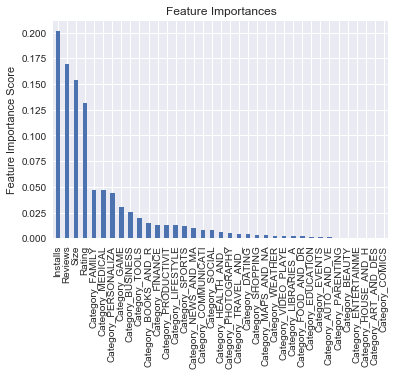

In [70]:
UnsortedNames = []
for col in subsetdf_NormalizedFinal.columns:
    UnsortedNames.append(col[0:20])


#Print Feature Importance:
feat_imp = pd.Series(model.feature_importances_, UnsortedNames).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

model.feature_importances_.sort_values(ascending=False)

In [58]:
# Try Random Forest Algorithm and Pick the best Parameter based on dev dataset
cs = np.arange(140, 180, 5)

train_accuracy_list = list()
dev_accuracy_list = list()

dev_recall_list = list()
dev_precision_list = list()
dev_f1score_list = list()

for c in cs:
    model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',n_estimators = c)
    model.fit(x_train_res,y_train_res)
    train_preds = model.predict(x_train_res)
    dev_preds   = model.predict(test_x)

    (train_score, dev_score) = (accuracy_score(y_train_res, train_preds), accuracy_score(test_y, dev_preds))
    
    # Find Recall and Precision Scores  
    train_score_r = recall_score(y_train_res, train_preds, pos_label=1, average="binary")
    train_score_p = precision_score(y_train_res, train_preds, pos_label=1, average="binary")
    
    dev_score_r = recall_score(test_y, dev_preds, pos_label=1, average="binary")
    dev_score_p = precision_score(test_y, dev_preds, pos_label=1, average="binary")
    dev_f1score = f1_score(test_y, dev_preds, pos_label=1, average="binary")
    
    # Collect Train and Dev Accuracy
    train_accuracy_list.append(train_score)
    dev_accuracy_list.append(dev_score)
    
    # Collect dev Precision and Recall 
    dev_recall_list.append(dev_score_r)
    dev_precision_list.append(dev_score_p)
    dev_f1score_list.append(dev_f1score)
    
  #  print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score, ",param:", c)
  #  print("Train Recall:", train_score_r, ", Train Precision:", train_score_p, ",param:", c)
    print("Dev Recall:", dev_score_r, ", Dev Precision:", dev_score_p, ",param:", c)

# Plot Train, Test Accuracy; Test set Precision and Recall scores
plot_TrainTestAccuracy(cs, train_accuracy_list, dev_accuracy_list)
plot_PrecisionRecall(cs,dev_precision_list, dev_recall_list)

Dev Recall: 0.4966442953020134 , Dev Precision: 0.6548672566371682 ,param: 140
Dev Recall: 0.4899328859060403 , Dev Precision: 0.6460176991150443 ,param: 145
Dev Recall: 0.47651006711409394 , Dev Precision: 0.6513761467889908 ,param: 150
Dev Recall: 0.4697986577181208 , Dev Precision: 0.6422018348623854 ,param: 155
Dev Recall: 0.4563758389261745 , Dev Precision: 0.6355140186915887 ,param: 160
Dev Recall: 0.48322147651006714 , Dev Precision: 0.6428571428571429 ,param: 165
Dev Recall: 0.4697986577181208 , Dev Precision: 0.6422018348623854 ,param: 170
Dev Recall: 0.5033557046979866 , Dev Precision: 0.646551724137931 ,param: 175


NameError: name 'plot_TrainTestAccuracy' is not defined